# RenAIssance: OCR for Seventeenth Century Spanish Texts

## Description
RenAIssance project aims to utilize optical character recognition (OCR) to digitize text sources not yet addressed by current tools. The competition leverages machine learning techniques to enable OCR on various undigitized materials. Specifically, it focuses on AI applications to recognize text in seventeenth-century Spanish printed sources, a niche largely ignored by existing OCR solutions.

Current OCR tools, like Adobe Acrobat’s OCR, struggle with transliteration from historical texts. These tools can recognize text from modern, clearly printed sources but fail with early print forms and manuscripts.

<p align="center">
<img src="https://github.com/ML4SCI/DeepLearnHackathon/blob/Renaissance/NLPRenaissanceChallenge/images/book_header.png?raw=true">
</p>

## Task
Develop a model to recognize text in the provided image dataset. Choose the best approach and explain your strategy.

This notebook demonstrates the use of Convolutional-Recurrent Neural Network (CRNN) architectures to solve the problem of Optical Character Recognition (OCR) for seventeenth-century Spanish texts. The model is trained on the given dataset, with transcriptions available for the first 25 pages. The remaining 6 pages are used for testing the model's performance. The goal is to improve the accuracy of the OCR model to achieve good results.

<p align="center">
<img src="https://github.com/ML4SCI/DeepLearnHackathon/blob/Renaissance/NLPRenaissanceChallenge/images/crnn_architecture.png?raw=true">
</p>

## Dataset
- The dataset consists of a scanned Spanish textbook with 31 pages.
- Transcriptions of the first 25 pages (ground truth) are available in a DOCX file.
- The first 25 pages will serve as your training and evaluation data.
- You need to submit the predicted text for the remaining 6 pages as the output of your model for testing purposes.

## Evaluation Metrics
Outline the evaluation metrics used to assess your model's performance. Consider the following:
- Character Error Rate (CER)
- Word Error Rate (WER)
- Precision, Recall, and F1 Score for text recognition

## Deliverables
- Fill out the pre- and post- hackathon surveys.
- A trained OCR model capable of recognizing text in the provided datasets.
- Predictions of the last 6 pages of the provided book in a text file.
- A brief report discussing the chosen approach, model architecture, training process, and evaluation results.
- Example usage notebook demonstrating the model's performance on sample data.

# Installing necessary packages, can ask the users to restart the notebook

In [ ]:
!pip install scikit-image PyMuPDF python-docx opencv-python scipy torch torchvision==0.2.1 pillow==8.3.1

You will be prompted to Restart the session. Continue running the cells after restarting

# Importing the necessary modules

In [ ]:
# Data Pre-processing
import fitz
import cv2
import csv
import os
from docx import Document
import string
import requests
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from IPython.display import clear_output as cls

# Data
from glob import glob
from tqdm import tqdm
import tensorflow.data as tfd

# Data Visualization
import matplotlib.pyplot as plt

# Model
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers

# Downloading the dataset

In [ ]:
# Downloading the Dataset on collab/local notebook
!gdown http://drive.google.com/uc?id=10NX_UbV2HMbPEO2fvKYAIXOOOec0g38g  # Downloading link for Ancient Text
!gdown http://drive.google.com/uc?id=1YTaqNoZCYP74AuQxlyJsiQLhcoc8DNSv  # Downloading link for Ground Truth Text

Downloading...
From: http://drive.google.com/uc?id=10NX_UbV2HMbPEO2fvKYAIXOOOec0g38g
To: /content/Padilla - Nobleza virtuosa_testExtract.pdf
100% 2.58M/2.58M [00:00<00:00, 165MB/s]
Downloading...
From: http://drive.google.com/uc?id=1YTaqNoZCYP74AuQxlyJsiQLhcoc8DNSv
To: /content/Padilla - 1 Nobleza virtuosa_testTranscription.docx
100% 29.1k/29.1k [00:00<00:00, 77.7MB/s]


In [ ]:
response = requests.get("https://raw.githubusercontent.com/ML4SCI/DeepLearnHackathon/main/NLPRenaissanceChallenge/utils.py")
if response.status_code == 200:
    with open("utils.py", "w") as file:
        file.write(response.text)

In [ ]:
!ls

'Padilla - 1 Nobleza virtuosa_testTranscription.docx'   sample_data
'Padilla - Nobleza virtuosa_testExtract.pdf'	        utils.py


# Pre-processing the dataset

### Converting PDF to images

In [ ]:
from utils import pdf_to_images

pdf_path = "./Padilla - Nobleza virtuosa_testExtract.pdf"  # Path to your PDF file
output_folder = "/content/preprocessing/imgsUnProcessed"  # Output folder to save the images
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
pdf_to_images(pdf_path, output_folder)

<img src="https://raw.githubusercontent.com/ML4SCI/DeepLearnHackathon/main/NLPRenaissanceChallenge/images/imageOriginal.png">

### Splitting two sided scanned images into individual pages.

In [ ]:
#Segregating 2-sided pages into individual pages
from utils import process_images

image_folder = "/content/preprocessing/imgsUnProcessed"
output_folder = "./imgsForAllPages"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
process_images(image_folder, output_folder)
print("Image processing complete!")

Image processing complete!


In [ ]:
!git clone https://github.com/ML4SCI/DeepLearnHackathon.git

Cloning into 'DeepLearnHackathon'...
remote: Enumerating objects: 561, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 561 (delta 30), reused 24 (delta 24), pack-reused 509
Receiving objects: 100% (561/561), 90.99 MiB | 26.86 MiB/s, done.
Resolving deltas: 100% (304/304), done.


# Text Detection
### Extracting words from a scanned text page image can be achieved using any model of your choice. We are using the [CRAFT Model](https://github.com/clovaai/CRAFT-pytorch) for the same. (This will take 3-4 mins to process the entire model)

In [ ]:
#It generally takes about ~3-4 mins
!python3 /content/DeepLearnHackathon/NLPRenaissanceChallenge/CRAFT/BoundBoxFunc/test.py --trained_model='/content/DeepLearnHackathon/NLPRenaissanceChallenge/CRAFT/BoundBoxFunc/weights/craft_mlt_25k.pth'

Loading weights from checkpoint (/content/DeepLearnHackathon/NLPRenaissanceChallenge/CRAFT/BoundBoxFunc/weights/craft_mlt_25k.pth)
elapsed time : 101.32952451705933s


In [ ]:
!mv /content/imgsForAllPages /content/preprocessing/imgsForAllPages

### The output of this model provides coordinates of the polygon enclosing the word. Using these coordinates one can draw a bounding box and crop word images.

In [ ]:
#Sorting the BB based on the Spanish writing style
from utils import process_bounding_boxes

# Path to the directory containing text files
input_directory = "./BoundBoxApplied"
output_directory = "/content/preprocessing/BoundBoxSorted"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over each text file in the directory
for filename in os.listdir(input_directory):
    if filename.endswith(".txt"):
        file_path = os.path.join(input_directory, filename)
        sorted_bounding_boxes = process_bounding_boxes(file_path)

        # Write sorted bounding boxes to text file in output directory
        output_file_path = os.path.join(output_directory, f"{os.path.splitext(filename)[0]}_sorted.txt")
        with open(output_file_path, "w") as outfile:
            for group in sorted_bounding_boxes:
                for box in group:
                    outfile.write(','.join(map(str, box)) + '\n')
                outfile.write((';'))

<img src="https://raw.githubusercontent.com/ML4SCI/DeepLearnHackathon/main/NLPRenaissanceChallenge/images/imageCRAFT.jpg">

### Extracting all the words from .docx file containing Transcription (True lables).

In [ ]:
#ground truth to text code
from utils import save_pages_to_text

docx_file = "/content/Padilla - 1 Nobleza virtuosa_testTranscription.docx"
output_file = "/content/preprocessing/all_text.txt"     # File where the text will be saved
save_pages_to_text(docx_file, output_file)

### Since we have processed our text book into individual pages, we need to split the entire transcription based on text pages.

In [ ]:
#splitting text files, based on the text
from utils import process_textfiles

textfile = '/content/preprocessing/all_text.txt'
sorted_BoundBox_folder = '/content/preprocessing/BoundBoxSorted'
output_folder = "/content/preprocessing/textSplitted"  # Replace with your output folder path
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
process_textfiles(textfile, sorted_BoundBox_folder, output_folder)
print("Text splitting complete!")

31 files in the folder
Text splitting complete!


### Extracts and saves bounding boxes from images using text data for filenames, skipping the last 6 images for testing.

In [ ]:
from utils import apply_extraction_to_folder_for_train

# Example usage
image_folder = '/content/preprocessing/imgsForAllPages'
bounding_box_folder = '/content/preprocessing/BoundBoxSorted'
text_folder = '/content/preprocessing/textSplitted'
# !mkdir output
output_folder = '/content/output'
apply_extraction_to_folder_for_train(image_folder, bounding_box_folder, text_folder, output_folder)

###  Extracts and saves bounding boxes from images using a numeric counter for filenames, skipping the first 25 images.

In [ ]:
from utils import apply_extraction_to_folder_for_test

# image_folder = '/content/BoundBoxApplied'
image_folder = '/content/preprocessing/imgsForAllPages'
bounding_box_folder = '/content/preprocessing/BoundBoxSorted'
word = 0
output_folder = '/content/outputTest'
apply_extraction_to_folder_for_test(image_folder, bounding_box_folder, output_folder, word)


image_26
image_27
image_28
image_29
image_30
image_31


### Creates a CSV file listing all files in a specified folder, excluding files named ".png", with columns for the filename and its identity (name without extension).

In [ ]:
from utils import create_csv_from_folder

# Train data
folder_path = "./output"  # Use raw string or double backslashes
csv_file_path = './outputs.csv'  # Use raw string or double backslashes
create_csv_from_folder(folder_path, csv_file_path)

# Test data
folder_path = "./outputTest"  # Use raw string or double backslashes
csv_file_path = './outputsTest.csv'  # Use raw string or double backslashes
create_csv_from_folder(folder_path, csv_file_path)

CSV file "./outputs.csv" created successfully.
CSV file "./outputsTest.csv" created successfully.


### Splitting train and test dataset

In [ ]:
df = pd.read_csv('outputs.csv')
df_train = df.iloc[:1000]
df_valid = df.iloc[1001:]

In [ ]:
df_train.to_csv('train.csv', index=False)
df_train.head()

,FILENAME,IDENTITY
0,maquinas.png,maquinas
1,puntos.png,puntos
2,dexaros.png,dexaros
3,ojos.png,ojos
4,"suyo,.png","suyo,"


In [ ]:
df_valid.to_csv('valid.csv', index=False)
df_valid.head()

,FILENAME,IDENTITY
1001,lo.png,lo
1002,venia.png,venia
1003,traerle.png,traerle
1004,A.png,A
1005,adelante.png,adelante


### This code sets up configuration parameters and file paths for training, validating, and testing an OCR model, including image size, batch size, number of epochs, model name, callbacks, learning rate, random seeds, dataset file paths, data sizes, and prefetching settings.

In [ ]:
# Image Size
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# Batch Size
BATCH_SIZE = 16

# EPOCHS
EPOCHS = 200

# Model Name
MODEL_NAME = 'SpanishOCR'

# Callbacks
CALLBACKS = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint(filepath=MODEL_NAME + ".h5", save_best_only=True)
]

# Learning Rate
LEARNING_RATE = 1e-3

# Random Seed
np.random.seed(2569)
tf.random.set_seed(2569)

# File Paths
train_csv_path = '/content/train.csv'
valid_csv_path = '/content/valid.csv'
test_csv_path = '/content/outputsTest.csv'

train_image_dir = '/content/output'
valid_image_dir = '/content/output'
test_image_dir = '/content/outputTest'

# Data Size
TRAIN_SIZE = BATCH_SIZE * 1000
VALID_SIZE = BATCH_SIZE * 500
TEST_SIZE  = BATCH_SIZE * 100

# AUTOTUNE
AUTOTUNE = tfd.AUTOTUNE

In [ ]:
# Train CSV
train_csv = pd.read_csv(train_csv_path)[:TRAIN_SIZE]

# Validation CSV
valid_csv = pd.read_csv(valid_csv_path)[:VALID_SIZE]

# Test CSV
test_csv = pd.read_csv(test_csv_path)[:TEST_SIZE]

In [ ]:
# In order to convert int to string to prevent tf error
test_csv['IDENTITY'] = test_csv['IDENTITY'].apply(lambda x: str(x))

In [ ]:
combo_csv = pd.read_csv("/content/outputs.csv")
labels = [str(word) for word in combo_csv['IDENTITY'].to_numpy()]
labels[:10]

['maquinas',
 'puntos',
 'dexaros',
 'ojos',
 'suyo,',
 'Virtud',
 'Angeles',
 'suya',
 'fuerza',
 'candalo']

### This code extracts unique characters from the dataset labels, calculates the total number of unique characters, and prints both the count and the set of unique characters

In [ ]:
# Unique characters
unique_chars = set(char for word in labels for char in word)
n_classes = len(unique_chars)

# Show
print(f"Total number of unique characters : {n_classes}")
print(f"Unique Characters : \n{unique_chars}")

Total number of unique characters : 60
Unique Characters : 
{'a', 'm', 'H', 's', 'U', ',', 'E', 'R', 'ú', 'f', 'h', 'v', 'ñ', ')', 'C', 'é', 'e', 'n', ':', 'á', 'Q', 'y', 'p', 'x', 'V', 'J', 'Y', 'L', '(', ';', 'q', 'g', 'G', 'i', 'b', 'z', 'D', 'c', 'T', 'A', 'd', 't', 'r', 'S', 'P', 'l', 'j', 'F', 'í', 'ó', '.', 'o', 'M', 'N', '<', 'I', 'B', 'O', '-', 'u'}


In [ ]:
MAX_LABEL_LENGTH = max(map(len, labels))
print(f"Maximum length of a label : {MAX_LABEL_LENGTH}")

Maximum length of a label : 17


### This code updates the file paths in the FILENAME columns of the training, validation, and test CSV dataframes by prepending the respective image directory paths to each filename.

In [ ]:
train_csv['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_csv['FILENAME']]
valid_csv['FILENAME'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['FILENAME']]
test_csv['FILENAME']  = [test_image_dir + f"/{filename}" for filename in test_csv['FILENAME']]

In [ ]:
train_csv.head()

,FILENAME,IDENTITY
0,/content/output/maquinas.png,maquinas
1,/content/output/puntos.png,puntos
2,/content/output/dexaros.png,dexaros
3,/content/output/ojos.png,ojos
4,"/content/output/suyo,.png","suyo,"


### This code creates two dictionaries: one that maps unique characters to numeric values using StringLookup, and another that reverses this mapping, converting numeric values back to characters.

In [ ]:
# Character to numeric value dictionary
char_to_num = layers.StringLookup(
    vocabulary = list(unique_chars),
    mask_token = None
)

# Reverse dictionary
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

### This function loads an image from a given path, decodes it as a JPEG, converts it to a tensor, resizes and normalizes it, and then returns the processed image as a tensor.

In [ ]:
def load_image(image_path : str):
    '''
    This function loads and preprocesses images. It first receives the image path, which is used to
    decode the image as a JPEG using TensorFlow. Then, it converts the image to a tensor and applies
    two processing functions: resizing and normalization. The processed image is then returned by
    the function.

    Argument :
        image_path : The path of the image file to be loaded.

    Return:
        image : The loaded image as a tensor.
    '''

    # Read the Image
    image = tf.io.read_file(image_path)

    # Decode the image
    decoded_image = tf.image.decode_jpeg(contents = image, channels = 1)

    # Convert image data type.
    cnvt_image = tf.image.convert_image_dtype(image = decoded_image, dtype = tf.float32)

    # Resize the image
    resized_image = tf.image.resize(images = cnvt_image, size = (IMG_HEIGHT, IMG_WIDTH))

    # Transpose
    image = tf.transpose(resized_image, perm = [1, 0, 2])

    # Convert image to a tensor.
    image = tf.cast(image, dtype = tf.float32)

    # Return loaded image
    return image

### This function loads and preprocesses an image, converts a given label string into a sequence of numeric values, pads the numeric sequence to a fixed length, and returns a dictionary containing the processed image tensor and the label tensor.

In [ ]:
def encode_single_sample(image_path : str, label : str):

    '''
    The function takes an image path and label as input and returns a dictionary containing the processed image tensor and the label tensor.
    First, it loads the image using the load_image function, which decodes and resizes the image to a specific size. Then it converts the given
    label string into a sequence of Unicode characters using the unicode_split function. Next, it uses the char_to_num layer to convert each
    character in the label to a numerical representation. It pads the numerical representation with a special class (n_classes)
    to ensure that all labels have the same length (MAX_LABEL_LENGTH). Finally, it returns a dictionary containing the processed image tensor
    and the label tensor.

    Arguments :
        image_path : The location of the image file.
        label      : The text to present in the image.

    Returns:
        dict : A dictionary containing the processed image and label.
    '''

    # Get the image
    image = load_image(image_path)

    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')

    # Convert the characters into vectors
    vecs = char_to_num(chars)

    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)

    return {'image':image, 'label':vecs}

### This code splits the combined dataset into training and validation subsets, shuffles the data, and then creates batched and prefetched TensorFlow datasets for efficient data loading during model training.

In [ ]:
# Further split the training dataset into training and validation subsets
train_size = 1000  # 80% of the training data for training
val_size = len(combo_csv) - train_size  # Remaining 20% for validation

# Splitting the training dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(combo_csv['FILENAME'].to_list()), np.array(combo_csv['IDENTITY'].to_list()))
).shuffle(1000)

# Create training dataset
train_ds = train_ds.take(train_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create validation dataset
valid_ds = train_ds.skip(train_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)

### This code creates TensorFlow datasets for training, validation, and testing by loading image paths and labels, shuffling the training data, applying the encode_single_sample function to preprocess the images and labels, batching the data, and using prefetching for optimized data loading.

In [ ]:
# Training Data
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(train_csv['FILENAME'].to_list()), np.array(train_csv['IDENTITY'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# # Validation data
valid_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_csv['FILENAME'].to_list()), np.array(valid_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# # Testing data.
test_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(test_csv['FILENAME'].to_list()), np.array(test_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 1008
Validation Data Size : 464
Testing Data Size    : 864


### Resizes all images in the input folder to a specified size and saves them as PNG files in the output folder, ensuring the output directory exists.

In [ ]:
# Set the new size in pixels (width, height) according to your choice
def resize_images_in_folder(input_folder, new_size=(200,50)):
    # Loop through all files in the input folder
    for filename in os.listdir(input_folder):
        # Open the image
        with Image.open(os.path.join(input_folder, filename)) as img:
            # Resize the image
            resized_img = img.resize(new_size)
            # Save the resized image to the output folder
            output_filename = os.path.splitext(filename)[0] + '.png'  # Ensure output format is PNG
            resized_img.save(os.path.join(output_folder, output_filename))

input_folder = "/content/output"
resize_images_in_folder(input_folder)

input_folder = "/content/outputTest"
resize_images_in_folder(input_folder)

### Displays a grid of images with their true labels, and optionally their predicted labels if a model is provided, using Matplotlib for visualization.


In [ ]:
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):

    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID

    # Loading Data
    data = next(iter(data))
    images, labels = data['image'], data['label']

    # Iterate over the data
    for index, (image, label) in enumerate(zip(images, labels)):

        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()

        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')

        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

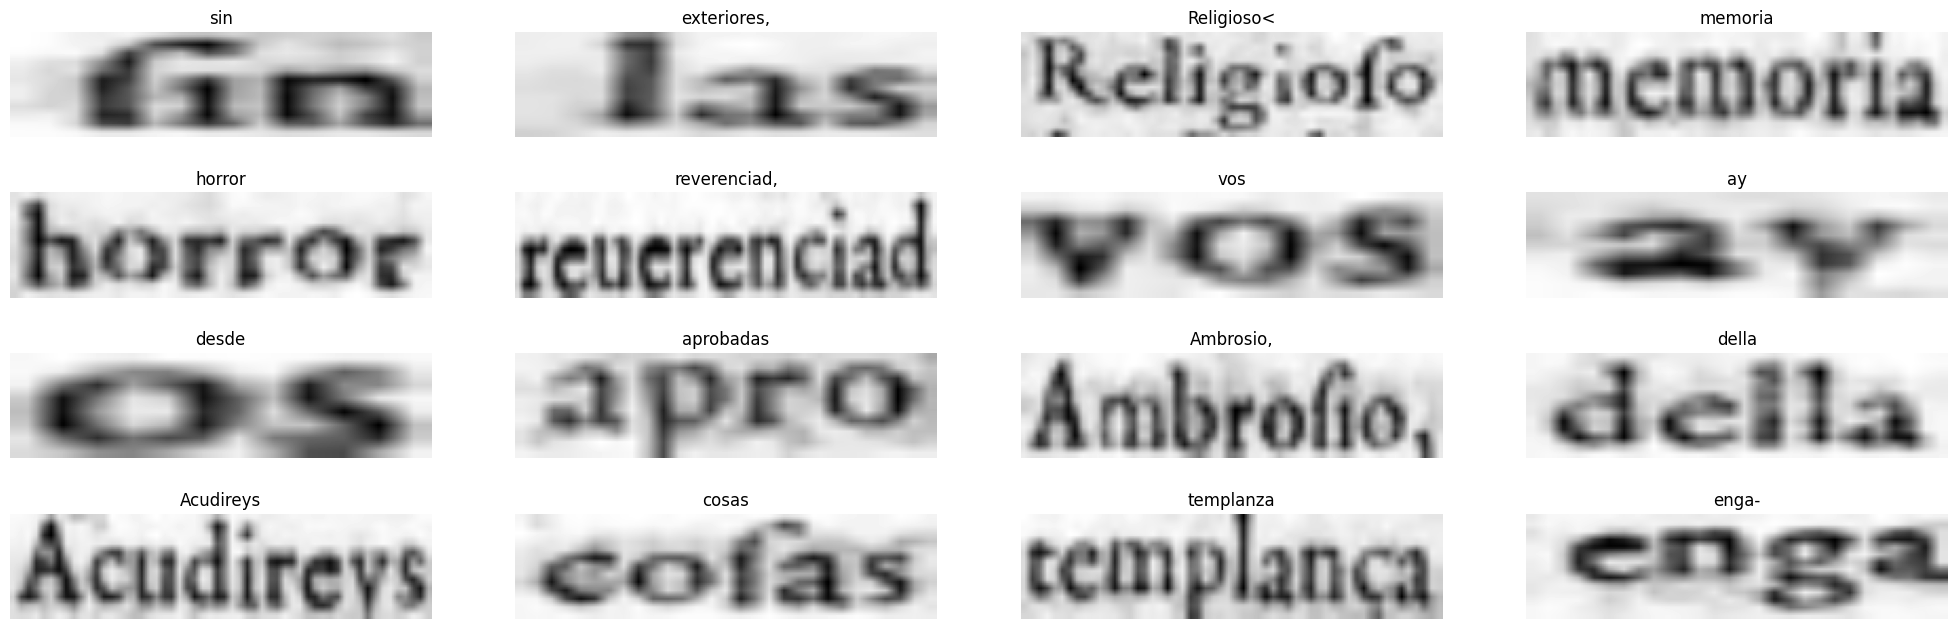

In [ ]:
show_images(data=train_ds, cmap='gray')

# Model Definition

### Defines a custom Keras layer that computes and adds the Connectionist Temporal Classification (CTC) loss to the model for training sequence-to-sequence prediction tasks.

In [ ]:
class CTCLayer(layers.Layer):

    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')

        input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_len, label_len)

        self.add_loss(loss)

        return y_pred

### Decodes the predicted labels from the OCR model, converting numeric values back to characters and removing unknown tokens to produce the final text output.

In [ ]:
def decode_pred(pred_label):

    '''
    The decode_pred function is used to decode the predicted labels generated by the OCR model.
    It takes a matrix of predicted labels as input, where each time step represents the probability
    for each character. The function uses CTC decoding to decode the numeric labels back into their
    character values. The function also removes any unknown tokens and returns the decoded texts as a
    list of strings. The function utilizes the num_to_char function to map numeric values back to their
    corresponding characters. Overall, the function is an essential step in the OCR process, as it allows
    us to obtain the final text output from the model's predictions.

    Argument :
        pred_label : These are the model predictions which are needed to be decoded.

    Return:
        filtered_text : This is the list of all the decoded and processed predictions.

    '''

    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]

    # CTC decode
    decode = keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]

    # Converting numerics back to their character values
    chars = num_to_char(decode)

    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]

    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]

    return filtered_texts

### This code defines a deep learning model for optical character recognition (OCR) using a combination of convolutional neural networks (CNNs) for feature extraction and bidirectional long short-term memory (LSTM) networks for sequence learning, concluding with a custom CTC loss layer for training.

In [ ]:
# Input Layer
input_images = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
target_labels = layers.Input(shape=(None, ), name="label")

# CNN Network
x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(input_images)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Encoding Space
encoding = layers.Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*64))(x)
encoding = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dropout(0.2)(encoding)

# RNN Network
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(encoding)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

# Output Layer
output = layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax')(x)

# CTC Layer
ctc_layer = CTCLayer()(target_labels, output)

# Model
ocr_model = keras.Model(
    inputs=[input_images, target_labels],
    outputs=[ctc_layer]
)

In [ ]:
# Model Summary
ocr_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 100, 25, 32)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 100, 25, 64)          18496     ['max_pooling2d[0][0]']   

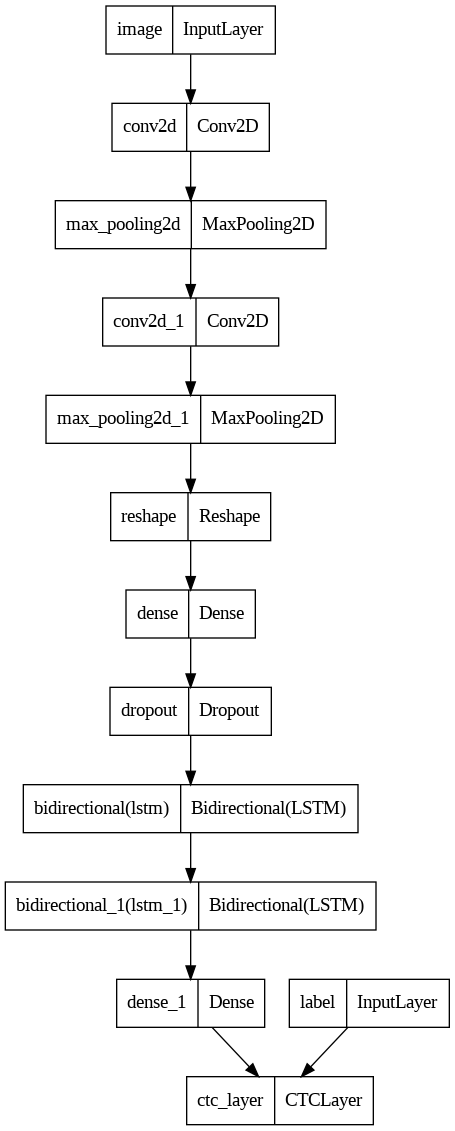

In [ ]:
tf.keras.utils.plot_model(ocr_model)

### Compiles the OCR model with the Adam optimizer and trains it on the training dataset with validation, using early stopping and model checkpoint callbacks.

In [ ]:
# Compile
ocr_model.compile(optimizer='adam')

# Train
history = ocr_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=CALLBACKS
)

Epoch 1/200
63/63 [==============================] - 16s 69ms/step - loss: 31.2180 - val_loss: 22.4684


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
63/63 [==============================] - 3s 55ms/step - loss: 21.8586 - val_loss: 22.0842
Epoch 3/200
63/63 [==============================] - 3s 40ms/step - loss: 21.3306 - val_loss: 21.4885
Epoch 4/200
63/63 [==============================] - 2s 36ms/step - loss: 20.8050 - val_loss: 20.9767
Epoch 5/200
63/63 [==============================] - 2s 36ms/step - loss: 20.4696 - val_loss: 21.4188
Epoch 6/200
63/63 [==============================] - 2s 36ms/step - loss: 20.2748 - val_loss: 20.8259
Epoch 7/200
63/63 [==============================] - 4s 56ms/step - loss: 20.1137 - val_loss: 20.6472
Epoch 8/200
63/63 [==============================] - 2s 37ms/step - loss: 20.0313 - val_loss: 20.5494
Epoch 9/200
63/63 [==============================] - 2s 35ms/step - loss: 19.9750 - val_loss: 20.5159
Epoch 10/200
63/63 [==============================] - 2s 35ms/step - loss: 19.9157 - val_loss: 20.4814
Epoch 11/200
63/63 [==============================] - 3s 43ms/step - loss: 19.861

### Creates an inference model from the trained OCR model for making predictions and prints the model summary.

In [ ]:
# Model required for inference
inference_model = keras.Model(
    inputs=ocr_model.get_layer(name="image").input,
    outputs=ocr_model.get_layer(name='dense_1').output
)

# Model summary
inference_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 200, 50, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 25, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 25, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 12, 64)        0         
 g2D)                                                            
                                                                 
 reshape (Reshape)           (None, 50, 768)           0   

In [ ]:
print(decode_pred(inference_model.predict(test_ds))[:10])   #convert to test_ds

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


54/54 [==============================] - 3s 21ms/step
['a', 'pedede', 'Sayri,', 'trales', 'ela', 'Sto', 'a', 'aniros', 'do', 'terir-']


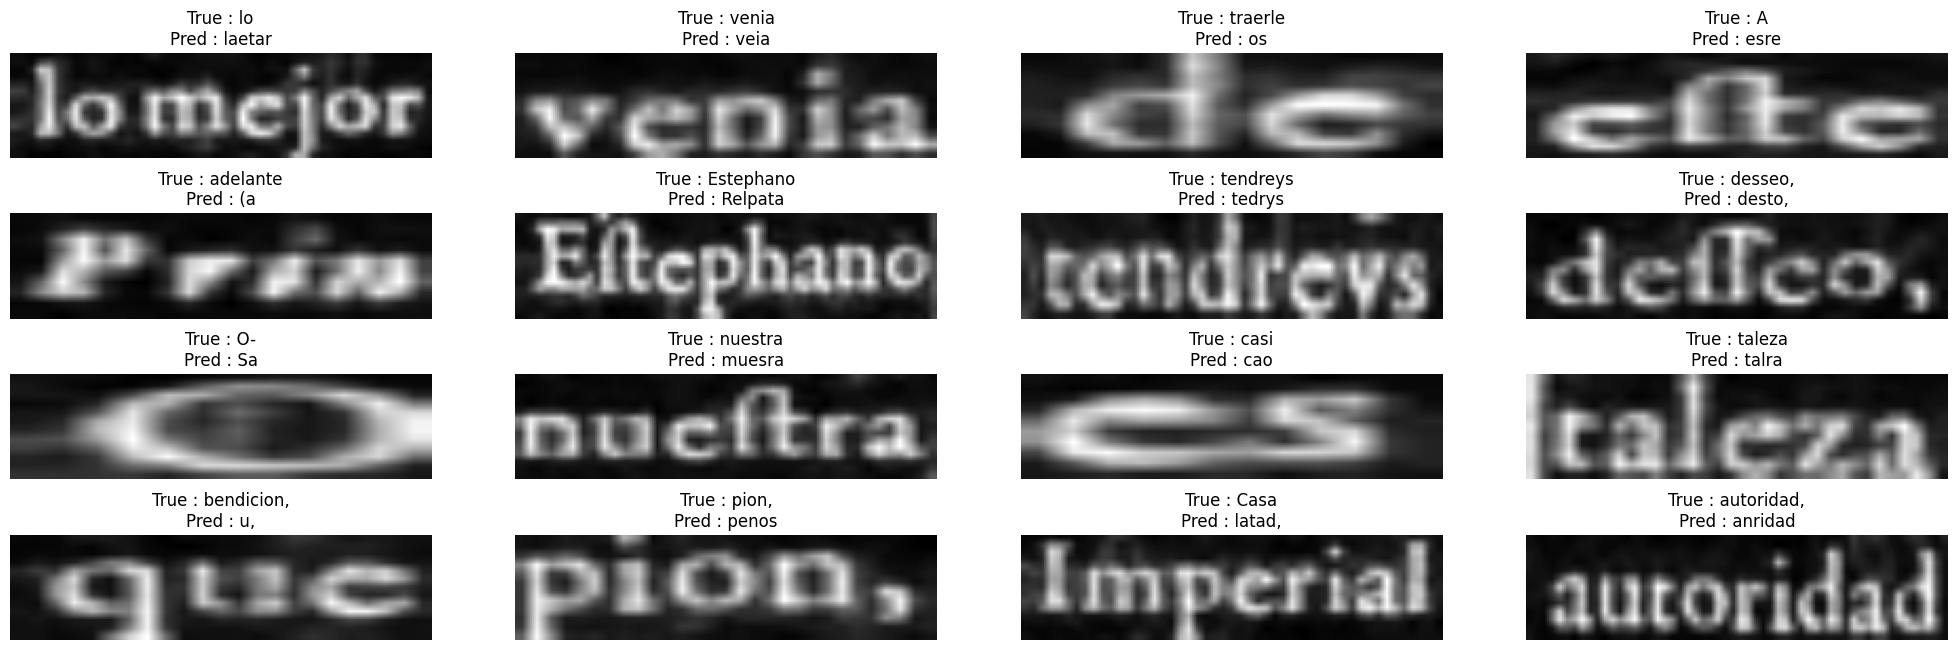

In [ ]:
show_images(data=valid_ds, model=inference_model, decode_pred=decode_pred, cmap='binary')

### Generates and decodes predictions from the inference model on the test dataset, printing the results in groups of 8 words per line.


In [ ]:
decoded_predictions = decode_pred(inference_model.predict(test_ds))

# Print decoded predictions in groups of 8 words per line (You will have to figure out a better and ideal approach, this is just for sample)
words_per_line = 8
for i in range(0, int(len(decoded_predictions)/10), words_per_line):
    print(' '.join(decoded_predictions[i:i+words_per_line]))

54/54 [==============================] - 1s 11ms/step
a pedede Sayri, trales ela Sto a aniros
do terir- Conrtas, vaa sla a sear pra
dalle Le dii nas ela teca sca ito
pao Sanre casa Conoseste, esda muesra poo o
Lines o po mo aeren h, s prpedad,
aes, ao peli- las macra ao ea cor-
sees ser- hion las  mutos devedo ao
da diescdo canda hos das ho os Eo
taro h laenia, preeton vao piuada rereior gaos
hes, as vose esio certdo veoos, to candles,
cada senalton, aa dandad canteas hays taar visro


## Contributors
- Shashank Shekhar Singh (Indian Institue of Technology, BHU)
- Utsav Rai (Imperial College London)
- Yukinori Yamamoto (Waseda University)
- Arsh Khan (VJTI, Mumbai)
- Xabier Granja (University of Alabama)
- Sergei Gleyzer (University of Alabama)
- Harrison Meadows (University of Tennessee)